In [66]:
import scanpy as sc
import gseapy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional
from scipy import sparse
from scipy import stats as scipy_stats
from tqdm import tqdm
import h5py
import warnings
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import precision_recall_curve, average_precision_score
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [67]:
class CellTypeGSEA:
    """
    A class to perform GSEA analysis between different cell types in single-cell data.
    """
    def __init__(
        self, 
        adata: sc.AnnData,
        cell_type_key: str = 'cell_type',
        gmt_file: str = None 
    ):
        """
        Initialize the GSEA analysis object.
        
        Parameters:
        -----------
        adata : AnnData
            Annotated data matrix with cell type annotations
        cell_type_key : str
            Key in adata.obs containing cell type labels
        gmt_file : str
            path to the gene set files (gmt format)
        """
        self.adata = adata
        self.cell_type_key = cell_type_key
        if gmt_file is not None:
            self.gene_sets = self._load_gmt_file(gmt_file)
        self.results = {}

    def _load_gmt_file(self, gmt_file):
        """
        Load and parse GMT file into dictionary format
        """
        gene_sets = {}
        with open(gmt_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 3:  # Skip malformed lines
                    continue
                pathway_name = parts[0]
                pathway_description = parts[1]
                genes = [gene for gene in parts[2:] if gene]  # Remove empty strings
                gene_sets[pathway_name] = genes
        
        print(f"Loaded {len(gene_sets)} gene sets")
        # Print first gene set as example
        first_set = next(iter(gene_sets.items()))
        print(f"\nExample gene set:")
        print(f"Name: {first_set[0]}")
        print(f"Number of genes: {len(first_set[1])}")
        print(f"First few genes: {first_set[1][:5]}")
        
        return gene_sets

    def compute_cell_type_rankings(
        self,
        cell_type: str
    ) -> pd.Series:
        """
        Compute differential expression rankings for one cell type vs all others.
        
        Parameters:
        -----------
        cell_type : str
            Cell type to analyze
            
        Returns:
        --------
        pd.Series
            Ranked gene list with ranking scores
        """
        # Create binary mask for cell type
        cell_mask = self.adata.obs[self.cell_type_key] == cell_type
        
        # Initialize results storage
        n_genes = self.adata.n_vars
        scores = np.zeros(n_genes)
        pvals = np.zeros(n_genes)
        
        # Get expression matrix
        if sparse.issparse(self.adata.X):
            X = self.adata.X.toarray()
        else:
            X = self.adata.X
        
        # Compute rankings for each gene
        for i in range(n_genes):
            gene_expr = X[:, i]
            
            # Perform Mann-Whitney U test
            stat, pval = scipy_stats.mannwhitneyu(
                gene_expr[cell_mask],
                gene_expr[~cell_mask],
                alternative='two-sided'
            )
            
            # Compute effect size (log2 fold change)
            mean_1 = np.mean(gene_expr[cell_mask])
            mean_2 = np.mean(gene_expr[~cell_mask])
            log2fc = np.log2((mean_1 + 1e-10) / (mean_2 + 1e-10))
            
            scores[i] = log2fc
            pvals[i] = pval
        
        # Create ranking metric
        # Add a small epsilon to p-values to avoid log10(0)
        min_pval = np.finfo(float).tiny  # Smallest positive float
        pvals = np.maximum(pvals, min_pval)
        ranking_metric = -np.log10(pvals) * np.sign(scores)
        
        # Create ranked gene list
        gene_names = [f'gene_{i}' for i in range(n_genes)] if self.adata.var_names.empty else self.adata.var_names
        rankings = pd.Series(
            ranking_metric,
            index=gene_names,
            name='ranking'
        ).sort_values(ascending=False)
        
        return rankings

    def run_gsea(
        self,
        min_size: int = 15,
        max_size: int = 500,
        permutations: int = 1000,
        threads: int = 4
    ) -> Dict:
        """
        Run GSEA analysis for all cell types.
        
        Parameters:
        -----------
        min_size : int
            Minimum gene set size
        max_size : int
            Maximum gene set size
        permutations : int
            Number of permutations
        threads : int
            Number of parallel threads
            
        Returns:
        --------
        Dict
            Dictionary containing GSEA results for each cell type
        """
        # Get unique cell types
        cell_types = self.adata.obs[self.cell_type_key].unique()
        
        print("Running GSEA analysis for each cell type...")
        for cell_type in tqdm(cell_types):
            # Get rankings for this cell type
            rankings = self.compute_cell_type_rankings(cell_type)
            
            # Run GSEA
            pre_res = gp.prerank(
                rnk=rankings,
                gene_sets=self.gene_sets,
                min_size=min_size,
                max_size=max_size,
                permutation_num=permutations,
                threads=threads,
                seed=42,
                no_plot=True
            )
            
            # Store results
            self.results[cell_type] = pre_res.res2d
            
        return self.results

    def plot_top_pathways(
        self,
        n_pathways: int = 10,
        fdr_cutoff: float = 0.05,
        figsize: tuple = (15, 10)
    ) -> None:
        """
            Plot top enriched pathways for each cell type.
            
            Parameters:
            -----------
            n_pathways : int
                Number of top pathways to show
            fdr_cutoff : float
                FDR cutoff for significance
            figsize : tuple
                Figure size
        """
        # Combine all results
        all_results = []
        for cell_type, res in self.results.items():
            df = res.copy()
            df['cell_type'] = cell_type
            all_results.append(df)
        
        combined_results = pd.concat(all_results)

        # Convert NES and FDR q-val to numeric
        combined_results['NES'] = pd.to_numeric(combined_results['NES'], errors='coerce')
        combined_results['FDR q-val'] = pd.to_numeric(combined_results['FDR q-val'], errors='coerce')
        
        # Filter significant pathways using standard boolean indexing
        sig_pathways = combined_results[combined_results['FDR q-val'] < fdr_cutoff]
        
        # Get top pathways for each cell type
        top_pathways_list = []
        for name, group in sig_pathways.groupby('cell_type'):
            top_n = group.nlargest(n_pathways, 'NES')
            top_pathways_list.append(top_n)
    
        top_pathways = pd.concat(top_pathways_list, ignore_index=True)
        
        # Create plot
        fig = plt.figure(figsize=figsize)
        # create FacetGrid
        g = sns.FacetGrid(
            data=top_pathways,
            col='cell_type',
            col_wrap=3,
            height=6,
            aspect=1.5
        )
        
        g.map_dataframe(
            sns.barplot,
            x='NES',
            y='Term',
            hue='FDR q-val',
            palette='RdBu_r'
        )

        # Adjust y-axis label spacing for each subplot
        for ax in g.axes.flat:
            ax.tick_params(axis='y', pad=15)  # Increase padding
            plt.setp(ax.get_yticklabels(), ha='right')  # Align labels

        # Add a colorbar legend
        norm = plt.Normalize(top_pathways['FDR q-val'].min(), fdr_cutoff)
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        sm.set_array([])
    
        # Add colorbar to the right of the subplots
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('FDR q-value')
    
        
        g.set_axis_labels('Normalized Enrichment Score', 'Pathway')
        g.figure.suptitle('Top Enriched Pathways by Cell Type', y=1.02)
        g.figure.tight_layout()

        # Adjust layout
        plt.subplots_adjust(
            right=0.9,
            wspace=0.4,
            hspace=0.4
        )
    
        # Return both the figure and the grid
        return g

    


In [68]:
# Usage:

### Load data
"run_20250121_150654_dataset_cell_type_generated_data.h5"
"run_20250121_150654_dataset_cell_type_generated_labels.csv"
"run_20250121_150654_dataset_cell_type_generated_data.csv"
# Set directory to save output files
output_dir = "/Users/guyshani/Documents/PHD/Aim_2/test_models/5000_genes/run_20250206_184657_dataset_singler_label/"
# Data path
file_path = "~/Documents/PHD/Aim_2/test_models/5000_genes/"
# Model generated data
expression_gen = "_generated_data.h5"
labels_gen = "_generated_labels.csv"
# Real data
#expression_real = "combined_normalized_data.h5"
#labels_real = "combined_metadata.csv"
expression_real = "full_matrix_top5000.h5"
labels_real = "metadata_top5000.csv"

# Load the gene symbols of my data
full_data = pd.read_csv(file_path+"full_matrix_top5000.csv", index_col=0)
gene_symbols = full_data.index.to_list()
#gene_symbols = pd.read_csv(file_path+"/combined_data.csv", nrows=1, sep=";", header=None).iloc[0]

### Generated data
# Load expression matrix generated data
with h5py.File(output_dir+expression_gen, 'r') as f:
    matrix = f['matrix'][:]
#with h5py.File(output_dir+expression_gen, 'r') as f:
#    matrix = np.array(f['matrix/data'])
# convert negative values to 0
matrix[matrix < 0 ] =0
# Load labels generatedd data
labels = pd.read_csv(output_dir+labels_gen)
# Create AnnData object
adataGen = sc.AnnData(matrix)
adataGen.var_names = gene_symbols
# Add cell type labels to adata
adataGen.obs['cell_type'] = labels.iloc[:, 2].values  # Assuming cell types are in the third column

### Real data
# Load expression matrix real data
#with h5py.File(file_path+expression_real, 'r') as f:
#    matrix = f['matrix'][:]

#with h5py.File(output_dir+expression_real, 'r') as f:
#    matrix = np.array(f['matrix/data'])
matrix = full_data.to_numpy()
# Load labels real data
labels = pd.read_csv(file_path+labels_real)

# Create AnnData object
adataReal = sc.AnnData(matrix.T)
adataReal.var_names = gene_symbols
# Add cell type labels to adata
adataReal.obs['cell_type'] = labels['singler_label'].values  # Assuming cell types are in the third column


Loaded 50 gene sets

Example gene set:
Name: HALLMARK_ADIPOGENESIS
Number of genes: 200
First few genes: ['Abca1', 'Abcb8', 'Acaa2', 'Acadl', 'Acadm']
Loaded 50 gene sets

Example gene set:
Name: HALLMARK_ADIPOGENESIS
Number of genes: 200
First few genes: ['Abca1', 'Abcb8', 'Acaa2', 'Acadl', 'Acadm']
Running GSEA analysis for each cell type...


 71%|███████▏  | 10/14 [03:01<01:13, 18.42s/it]2025-02-11 10:11:53,796 [WARNING] Duplicated values found in preranked stats: 1.88% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 79%|███████▊  | 11/14 [03:18<00:54, 18.03s/it]2025-02-11 10:12:12,023 [WARNING] Duplicated values found in preranked stats: 1.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 86%|████████▌ | 12/14 [03:36<00:36, 18.09s/it]2025-02-11 10:12:31,856 [WARNING] Duplicated values found in preranked stats: 1.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 93%|█████████▎| 13/14 [03:56<00:18, 18.63s/it]2025-02-11 10:12:50,153 [WARNING] Duplicated values found in preranked stats: 1.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
100%|██████████| 14/14 [04:14<00:00, 18.20s/it]


Running GSEA analysis for each cell type...


  0%|          | 0/14 [00:00<?, ?it/s]2025-02-11 10:13:04,690 [WARNING] Duplicated values found in preranked stats: 21.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  7%|▋         | 1/14 [00:14<03:09, 14.58s/it]2025-02-11 10:13:18,259 [WARNING] Duplicated values found in preranked stats: 30.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 14%|█▍        | 2/14 [00:28<02:47, 13.97s/it]2025-02-11 10:13:32,850 [WARNING] Duplicated values found in preranked stats: 37.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 21%|██▏       | 3/14 [00:42<02:36, 14.25s/it]2025-02-11 10:13:45,256 [WARNING] Duplicated values found in preranked stats: 29.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 29%|██▊       | 4/14 [00:55<02:15, 13.52s/it]2025-02-11 10:13:57,159 [WARNING] Duplicated values found in preranked sta

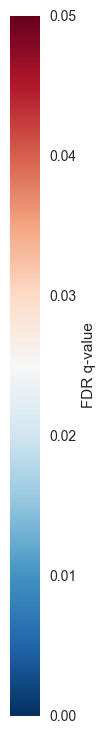

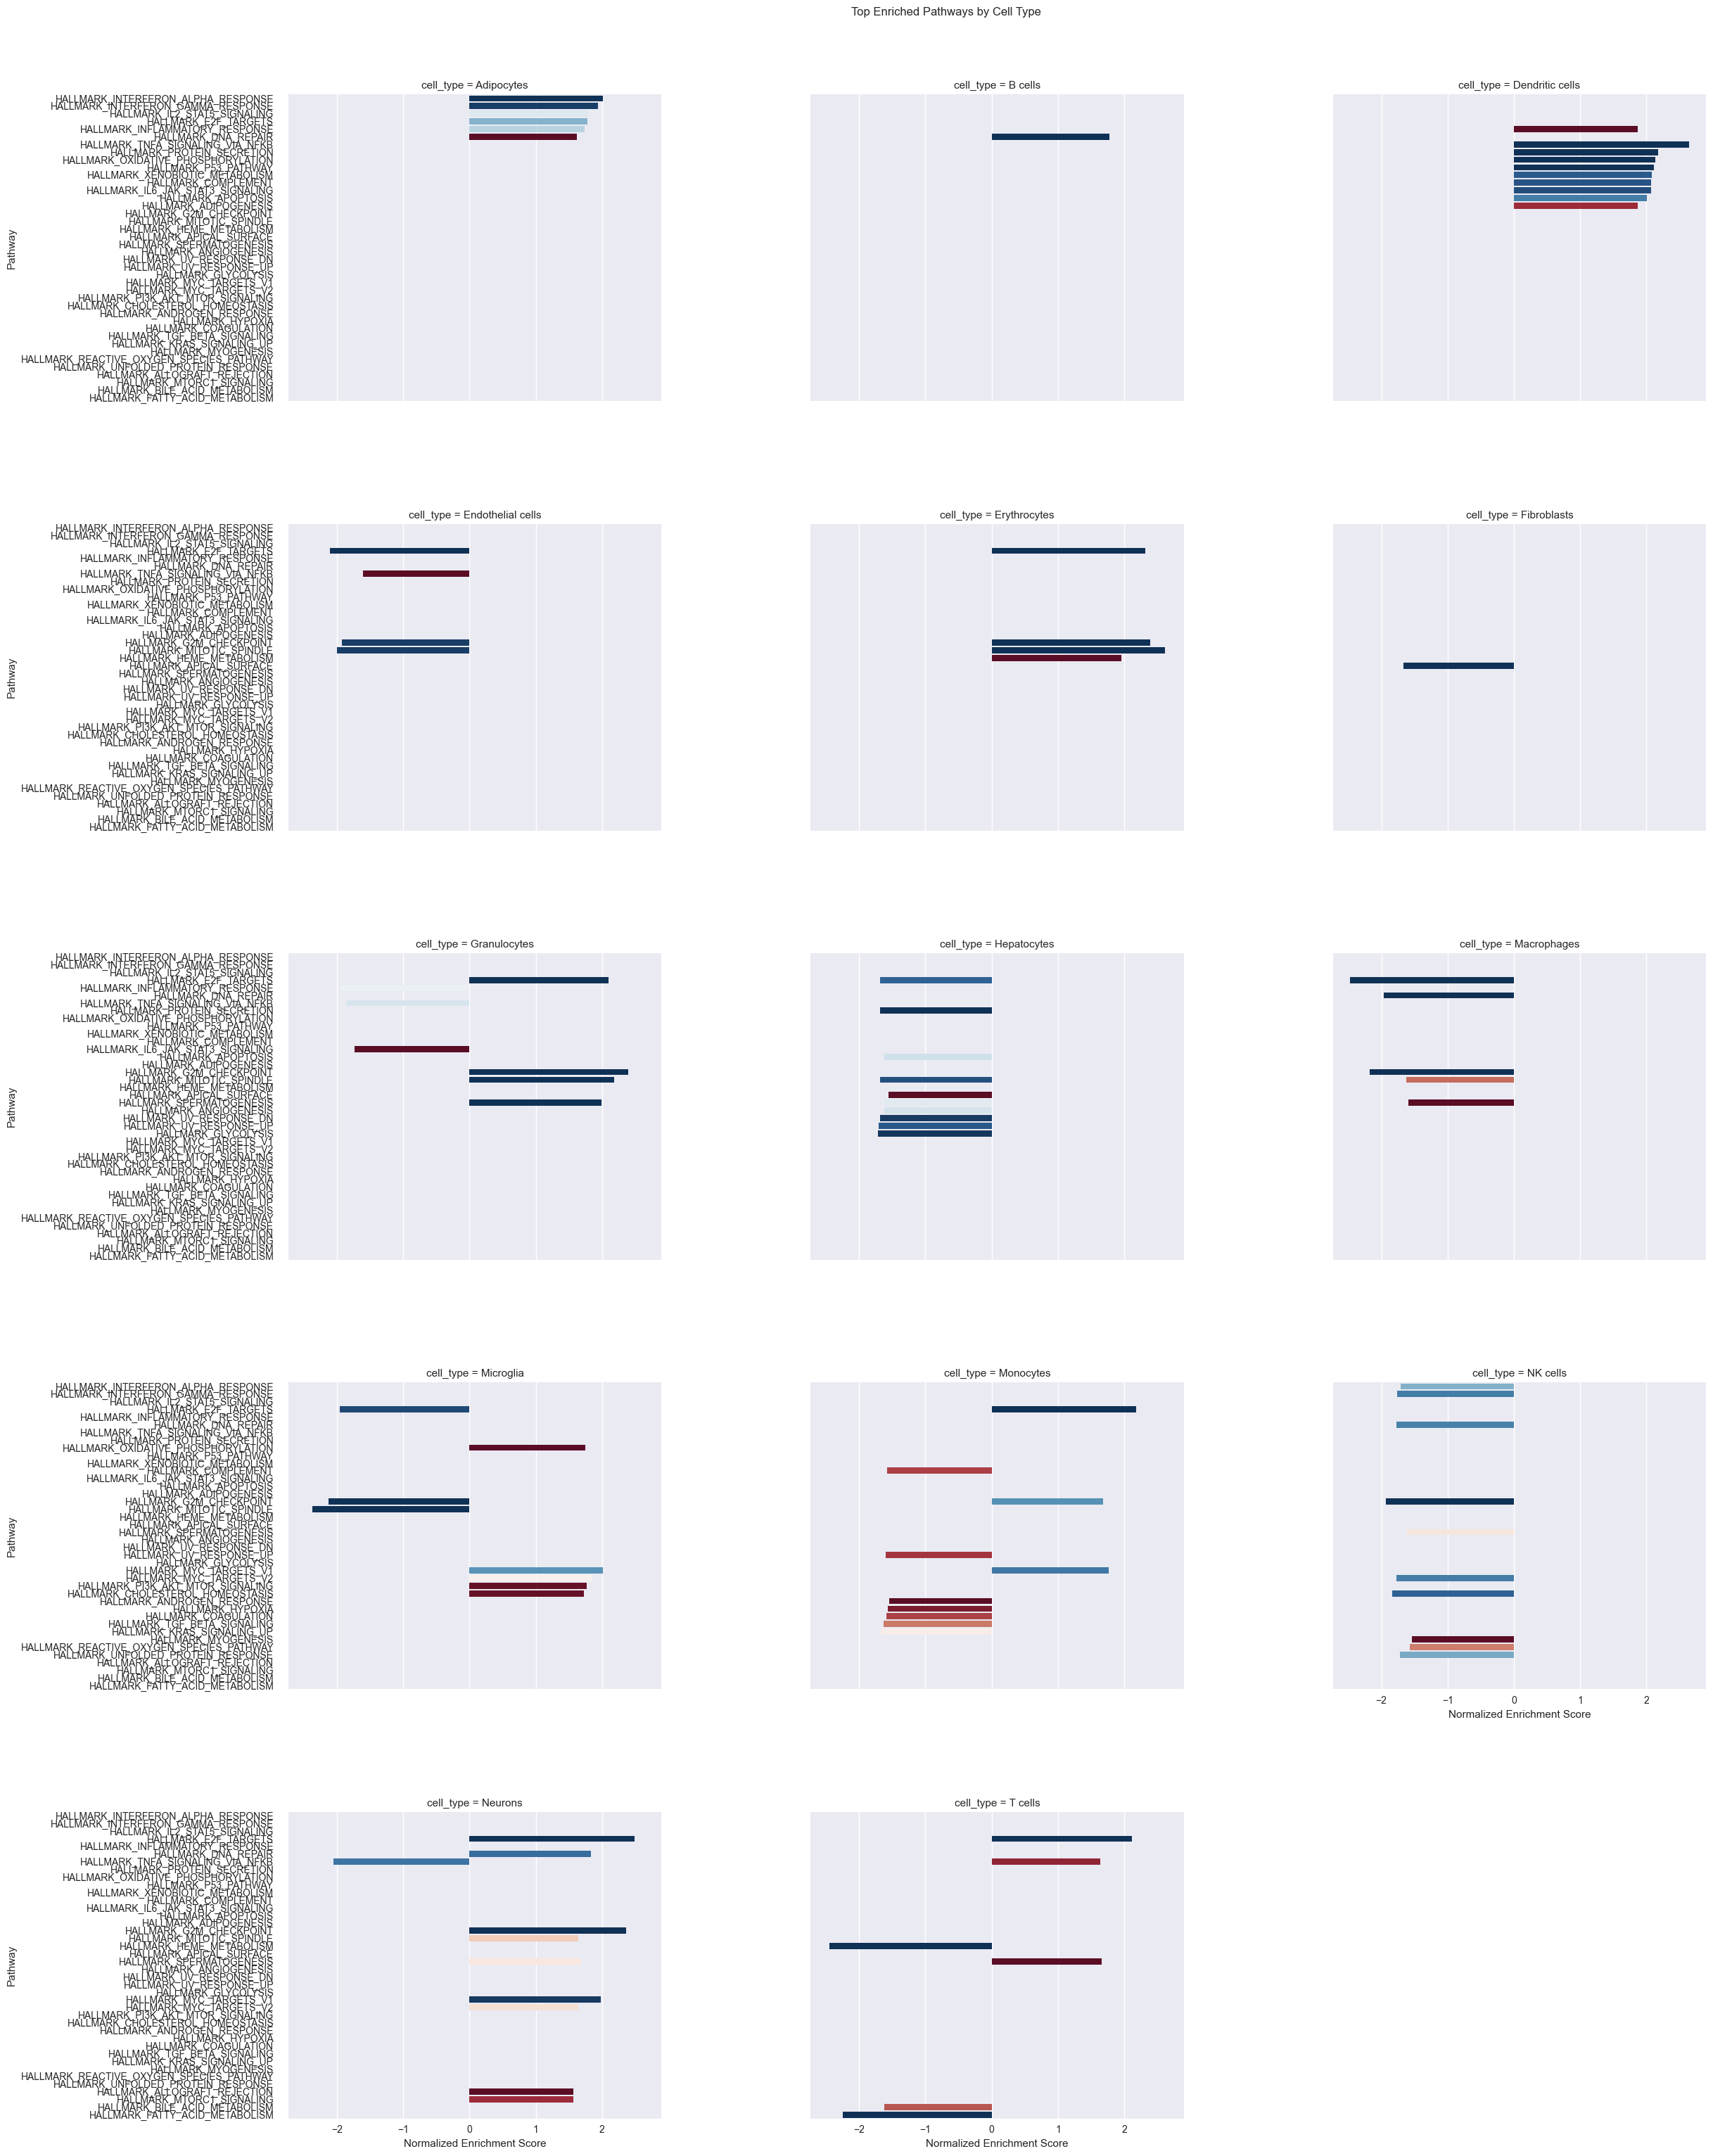

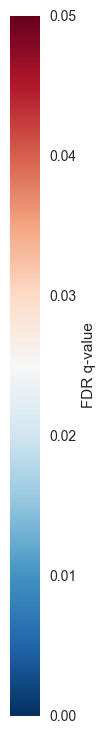

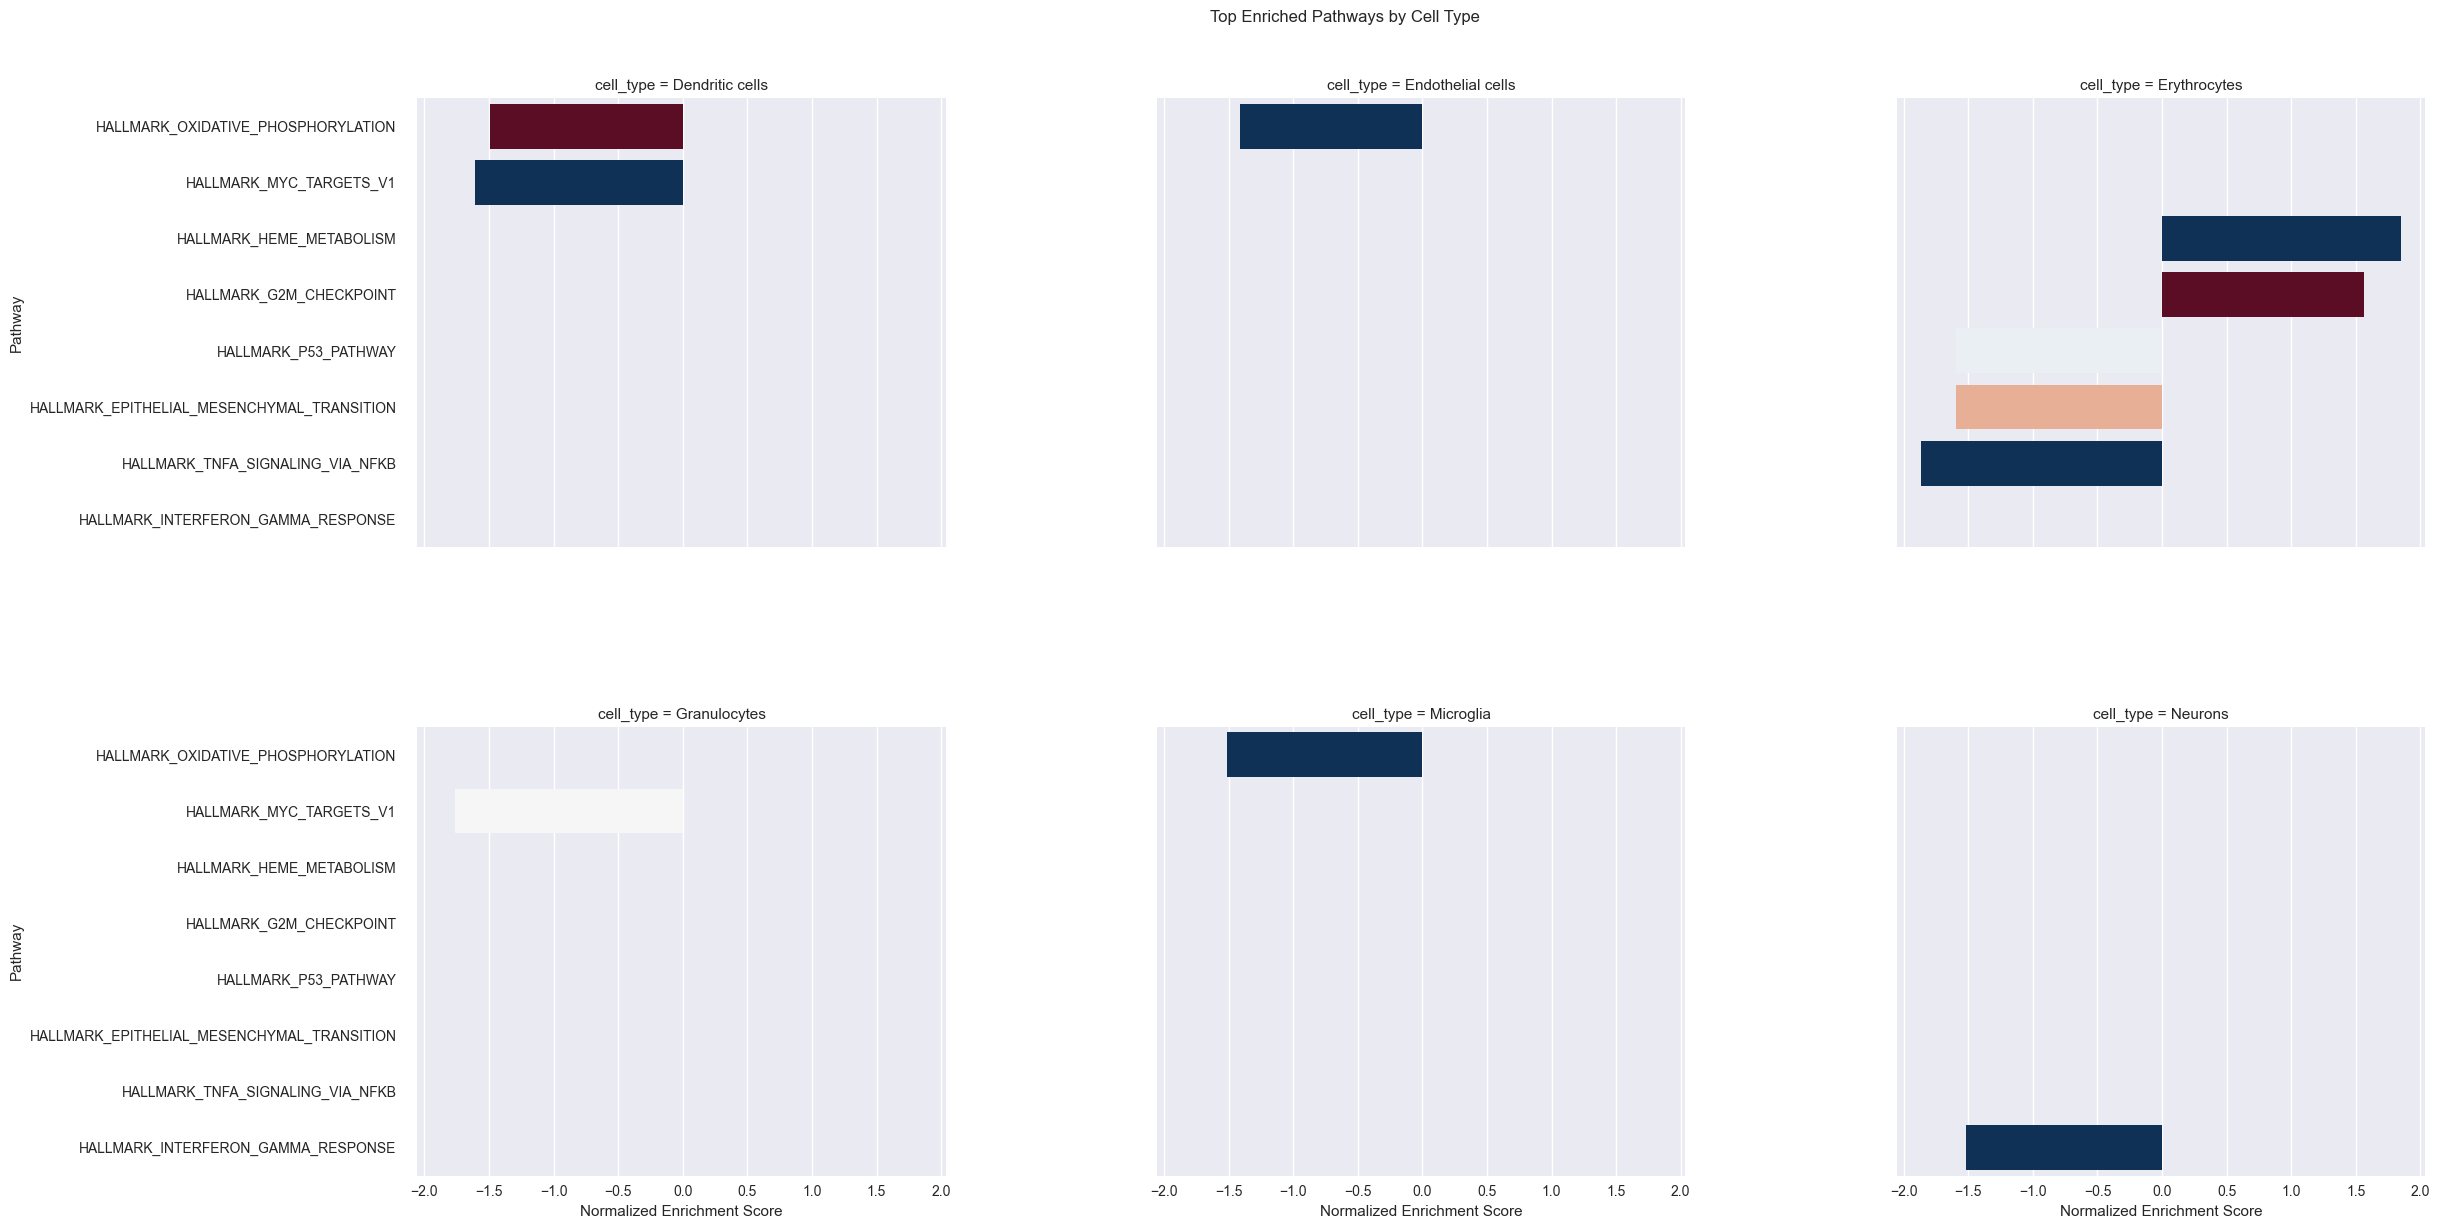

In [69]:
# /Users/guyshani/Documents/PHD/gene_sets/mh.all.v2024.1.Mm.symbols.gmt.txt
# /Users/guyshani/Documents/PHD/gene_sets/m8.all.v2024.1.Mm.symbols.gmt.txt

# Initialize GSEA analyzer
gsea_analyzer_gen = CellTypeGSEA(
    adataGen,
    cell_type_key='cell_type',
    gmt_file = '/Users/guyshani/Documents/PHD/gene_sets/mh.all.v2024.1.Mm.symbols.gmt.txt'
)
gsea_analyzer_real = CellTypeGSEA(
    adataReal,
    cell_type_key='cell_type',
    gmt_file = '/Users/guyshani/Documents/PHD/gene_sets/mh.all.v2024.1.Mm.symbols.gmt.txt'
)


# Run GSEA
resultsGen = gsea_analyzer_gen.run_gsea()
resultsReal = gsea_analyzer_real.run_gsea()

# Plot results
gG = gsea_analyzer_gen.plot_top_pathways()
gG.figure.savefig(output_dir+'gsea_gen_results.pdf', bbox_inches='tight', dpi=300)
gR = gsea_analyzer_real.plot_top_pathways()
gR.figure.savefig(output_dir+'gsea_real_results.pdf', bbox_inches='tight', dpi=300)

# Save results to CSV
for cell_type, res in resultsGen.items():
    res.to_csv(f'{output_dir}gsea_gen_results_{cell_type}.csv')
for cell_type, res in resultsReal.items():
    res.to_csv(f'{output_dir}gsea_real_results_{cell_type}.csv')

In [70]:
#list(resultsGen.keys())

# Organize both results into comparable dataframes
def prepare_results_df(results, suffix=''):
    all_results = []
    for cell_type, res in results.items():
        res = res.copy()
        res['cell_type'] = cell_type
        all_results.append(res)
    df = pd.concat(all_results)
    
    # Ensure NES is numeric
    df['NES'] = pd.to_numeric(df['NES'], errors='coerce')
    
    return df

# Prepare both dataframes
df_gen = prepare_results_df(resultsGen, '_gen')
df_real = prepare_results_df(resultsReal, '_real')

# Merge the dataframes on cell type and pathway term
merged_df = pd.merge(
    df_gen[['Term', 'cell_type', 'NES']].rename(columns={'NES': 'NES_gen'}),
    df_real[['Term', 'cell_type', 'NES']].rename(columns={'NES': 'NES_real'}),
    on=['Term', 'cell_type'],
    how='inner'
)

In [71]:

### Summary metrics calculation functions
def fishers_combined_probability(pvalues):
    """
    Implements Fisher's method for combining p-values.
    
    Parameters:
    -----------
    pvalues : array-like
        Array of p-values to combine
        
    Returns:
    --------
    tuple : (chi_square_statistic, combined_p_value)
    """
    # Convert to numpy array and check for valid p-values
    pvalues = np.array(pvalues)
    if np.any((pvalues < 0) | (pvalues > 1)):
        raise ValueError("All p-values must be between 0 and 1")
    
    chi_square = -2 * np.sum(np.log(pvalues))
    df = 2 * len(pvalues)
    combined_p = 1 - scipy_stats.chi2.cdf(chi_square, df)  # Using 1 - CDF instead of SF for clarity
    
    return chi_square, combined_p

def stouffers_z_score(z_scores, weights=None):
    """
    Implements Stouffer's Z-score method for combining Z-scores.
    
    Parameters:
    -----------
    z_scores : array-like
        Array of Z-scores to combine
    weights : array-like, optional
        Array of weights (e.g., sqrt of sample sizes). If None, equal weights are used.
        
    Returns:
    --------
    tuple : (combined_z_score, combined_p_value)
    """
    z_scores = np.array(z_scores)
    
    if weights is None:
        weights = np.ones_like(z_scores)
    else:
        weights = np.array(weights)
    
    weighted_sum = np.sum(weights * z_scores)
    combined_z = weighted_sum / np.sqrt(np.sum(weights**2))
    combined_p = 2 * (1 - scipy_stats.norm.cdf(abs(combined_z)))
    
    return combined_z, combined_p

def fishers_z_transform(correlations, sample_sizes):
    """
    Implements Fisher's Z-transformation method for combining correlation coefficients.
    
    Parameters:
    -----------
    correlations : array-like
        Array of correlation coefficients to combine
    sample_sizes : array-like
        Array of sample sizes corresponding to each correlation
        
    Returns:
    --------
    tuple : (combined_correlation, confidence_interval)
    """
    correlations = np.array(correlations)
    sample_sizes = np.array(sample_sizes)
    
    if np.any(abs(correlations) >= 1):
        raise ValueError("Correlation coefficients must be between -1 and 1")
    
    z_transforms = 0.5 * np.log((1 + correlations) / (1 - correlations))
    weights = sample_sizes - 3
    z_mean = np.sum(weights * z_transforms) / np.sum(weights)
    se = np.sqrt(1 / np.sum(weights))
    
    ci_z_lower = z_mean - 1.96 * se
    ci_z_upper = z_mean + 1.96 * se
    
    combined_r = (np.exp(2 * z_mean) - 1) / (np.exp(2 * z_mean) + 1)
    ci_lower = (np.exp(2 * ci_z_lower) - 1) / (np.exp(2 * ci_z_lower) + 1)
    ci_upper = (np.exp(2 * ci_z_upper) - 1) / (np.exp(2 * ci_z_upper) + 1)
    
    return combined_r, (ci_lower, ci_upper)


Combined Statistics Across Cell Types:
Fisher's Combined P-value (t-tests): 0.00e+00
Combined Correlation (Fisher's Z): -0.068 (95% CI: -0.146, 0.011)
Stouffer's Combined Z-score: -19.463 (p = 0.00e+00)

Statistical comparison results by cell type:
            cell_type  n_pathways  t_statistic  p_value  correlation  correlation_p  p_value_adj  correlation_p_adj
12        Hepatocytes          47    -1.54e+01 8.85e-20    -7.56e-02       6.13e-01     1.24e-18           7.16e-01
1     Dendritic cells          47     1.42e+01 1.76e-18     1.69e-01       2.56e-01     1.24e-17           3.99e-01
7           Monocytes          47    -1.34e+01 1.68e-17    -6.82e-01       1.31e-07     7.86e-17           9.16e-07
4         Fibroblasts          47    -1.17e+01 2.17e-15    -7.66e-01       3.40e-10     7.60e-15           4.76e-09
9             T cells          47     8.01e+00 2.86e-10     1.87e-01       2.08e-01     6.72e-10           3.64e-01
0             B cells          47     8.01e+00 2.88e-1

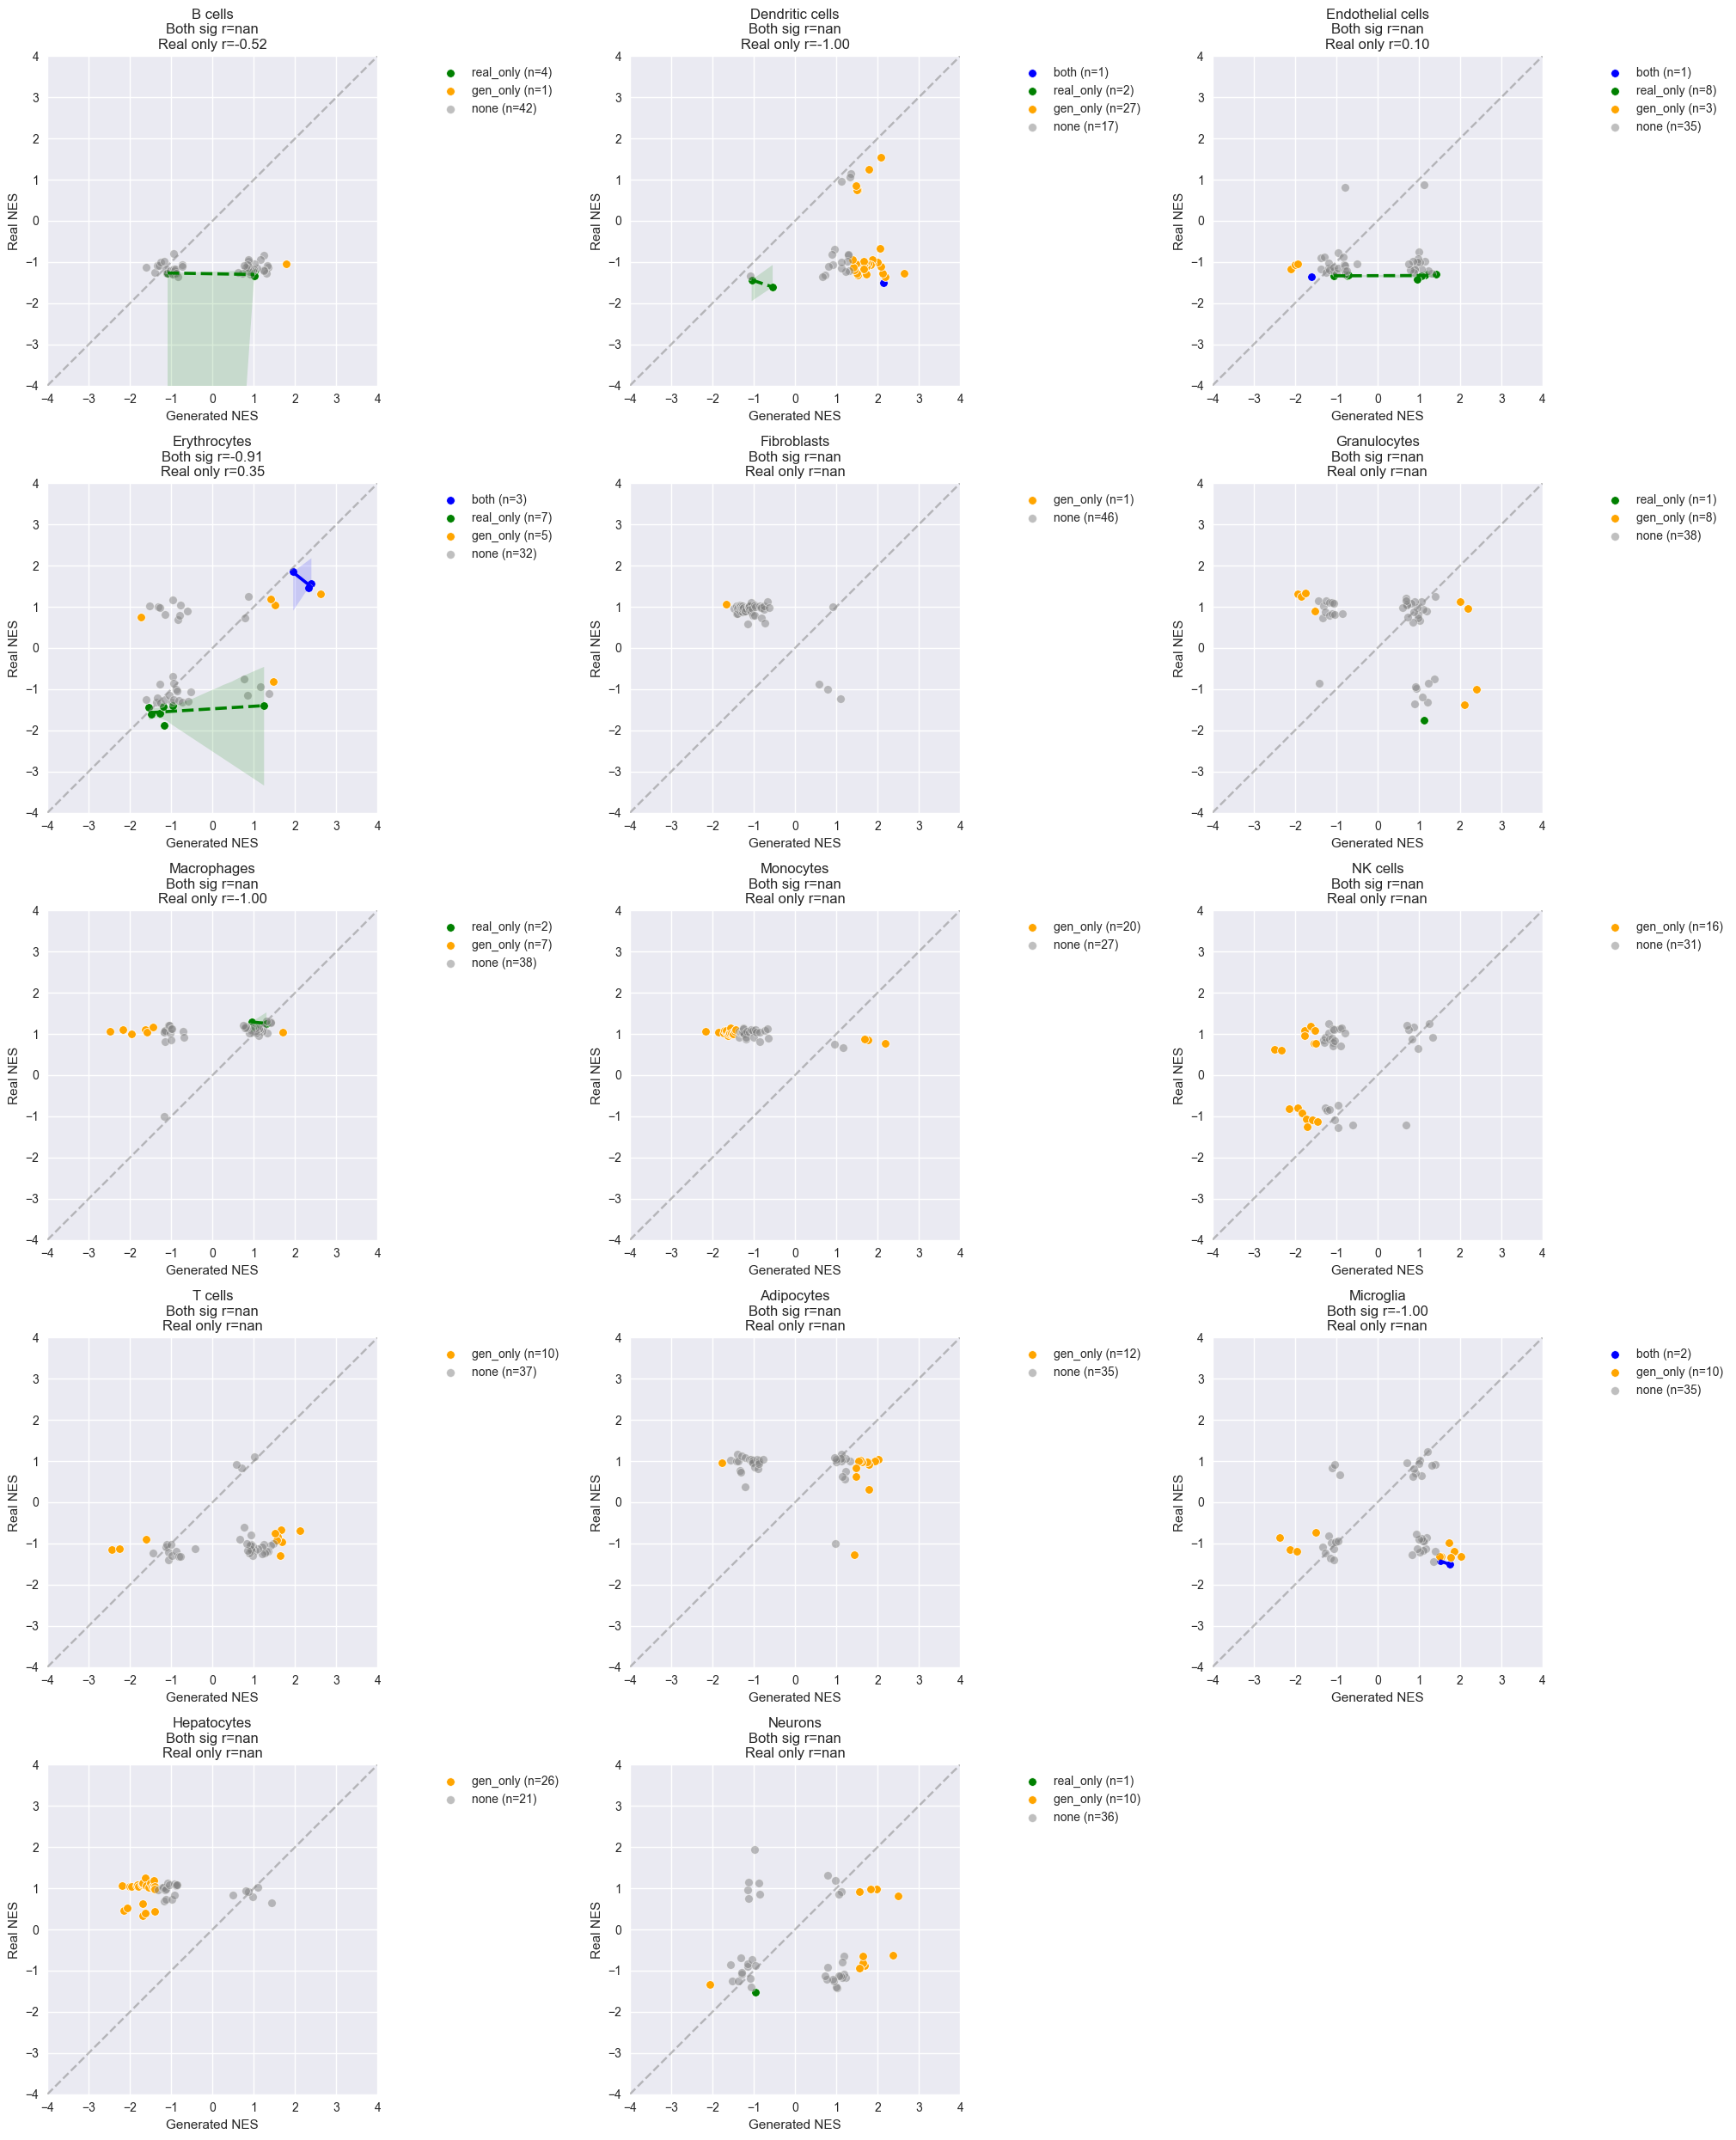

In [76]:
# Perform statistical test for each cell type
statistical_results = []
for cell_type in merged_df['cell_type'].unique():
    cell_data = merged_df[merged_df['cell_type'] == cell_type]
    # Perform paired t-test
    t_stat, p_val = scipy_stats.ttest_rel(
        cell_data['NES_gen'],
        cell_data['NES_real']
    )
    # Calculate correlation
    corr, corr_p = scipy_stats.pearsonr(
        cell_data['NES_gen'],
        cell_data['NES_real']
    )
    statistical_results.append({
        'cell_type': cell_type,
        'n_pathways': len(cell_data),
        't_statistic': t_stat,
        'p_value': p_val,
        'correlation': corr,
        'correlation_p': corr_p
    })

# Convert results to dataframe
results_df = pd.DataFrame(statistical_results)

# Add multiple testing correction
_, results_df['p_value_adj'] = fdrcorrection(results_df['p_value'])
_, results_df['correlation_p_adj'] = fdrcorrection(results_df['correlation_p'])

# Calculate combined statistics across all cell types
# 1. Fisher's combined probability for t-test p-values
chi_square_t, combined_p_t = fishers_combined_probability(results_df['p_value'])

# 2. Fisher's Z-transformation for correlations
correlations = results_df['correlation'].values
sample_sizes = results_df['n_pathways'].values
combined_r, ci_r = fishers_z_transform(correlations, sample_sizes)

# 3. Convert t-statistics to z-scores and use Stouffer's method
# Note: for t-statistics, we can convert to z-scores using the survival function
z_scores = scipy_stats.norm.ppf(scipy_stats.t.sf(abs(results_df['t_statistic']), 
                                   df=results_df['n_pathways']-1))
weights = np.sqrt(results_df['n_pathways'])  # weight by sqrt of sample size
combined_z, combined_p_z = stouffers_z_score(z_scores, weights)

# Add combined statistics to results summary
print("\nCombined Statistics Across Cell Types:")
print(f"Fisher's Combined P-value (t-tests): {combined_p_t:.2e}")
print(f"Combined Correlation (Fisher's Z): {combined_r:.3f} (95% CI: {ci_r[0]:.3f}, {ci_r[1]:.3f})")
print(f"Stouffer's Combined Z-score: {combined_z:.3f} (p = {combined_p_z:.2e})")

# Sort by p-value
results_df = results_df.sort_values('p_value')

print("\nStatistical comparison results by cell type:")
print(results_df.to_string(float_format=lambda x: '{:.2e}'.format(x) if isinstance(x, float) else str(x)))

# Create subplot grid
n_cell_types = len(merged_df['cell_type'].unique())
n_cols = 3
n_rows = (n_cell_types + n_cols - 1) // n_cols

# Increase figure width to accommodate legend
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))  # Increased width from 15 to 20
axes = axes.flatten()

# Define colors for different significance categories
color_map = {
    'both': 'blue',
    'real_only': 'green',
    'gen_only': 'orange',
    'none': 'gray'
}

# Set axis limits
AXIS_MIN = -4
AXIS_MAX = 4

for idx, cell_type in enumerate(merged_df['cell_type'].unique()):
    cell_data = merged_df[merged_df['cell_type'] == cell_type]
    
    # Add p-values from both datasets
    cell_data = cell_data.merge(
        df_gen[['Term', 'cell_type', 'FDR q-val']].rename(columns={'FDR q-val': 'pvalue_gen'}),
        on=['Term', 'cell_type']
    )
    cell_data = cell_data.merge(
        df_real[['Term', 'cell_type', 'FDR q-val']].rename(columns={'FDR q-val': 'pvalue_real'}),
        on=['Term', 'cell_type']
    )
    
    # Categorize points based on significance
    cell_data['significance'] = 'none'
    cell_data.loc[(cell_data['pvalue_gen'] < 0.1) & (cell_data['pvalue_real'] < 0.1), 'significance'] = 'both'
    cell_data.loc[(cell_data['pvalue_real'] < 0.1) & (cell_data['pvalue_gen'] >= 0.1), 'significance'] = 'real_only'
    cell_data.loc[(cell_data['pvalue_gen'] < 0.1) & (cell_data['pvalue_real'] >= 0.1), 'significance'] = 'gen_only'
    
    # Calculate counts for each category
    sig_counts = cell_data['significance'].value_counts()
    
    # Calculate correlations for different categories
    correlations = {}
    for category in ['both', 'real_only']:
        cat_data = cell_data[cell_data['significance'] == category]
        if len(cat_data) > 1:
            corr, _ = scipy_stats.pearsonr(cat_data['NES_gen'], cat_data['NES_real'])
            correlations[category] = corr
        else:
            correlations[category] = float('nan')
    
    # Plot points for each category
    for category, color in color_map.items():
        cat_data = cell_data[cell_data['significance'] == category]
        alpha = 0.5 if category == 'none' else 1.0
        
        sns.scatterplot(
            data=cat_data,
            x='NES_gen',
            y='NES_real',
            color=color,
            alpha=alpha,
            ax=axes[idx],
            label=f"{category} (n={len(cat_data)})"
        )
    
    # Add correlation lines for significant categories
    for category, color in {'both': 'blue', 'real_only': 'green'}.items():
        cat_data = cell_data[cell_data['significance'] == category]
        if len(cat_data) > 1:
            sns.regplot(
                data=cat_data,
                x='NES_gen',
                y='NES_real',
                scatter=False,
                ax=axes[idx],
                color=color,
                line_kws={'linestyle': '-' if category == 'both' else '--'}
            )
    
    # Update title to show correlations
    title_lines = [cell_type]
    if 'both' in correlations:
        title_lines.append(f"Both sig r={correlations['both']:.2f}")
    if 'real_only' in correlations:
        title_lines.append(f"Real only r={correlations['real_only']:.2f}")
    
    axes[idx].set_title('\n'.join(title_lines))
    axes[idx].set_xlabel('Generated NES')
    axes[idx].set_ylabel('Real NES')
    
    # Set axis limits
    axes[idx].set_xlim(AXIS_MIN, AXIS_MAX)
    axes[idx].set_ylim(AXIS_MIN, AXIS_MAX)
    
    # Add diagonal line within the limited range
    axes[idx].plot([AXIS_MIN, AXIS_MAX], [AXIS_MIN, AXIS_MAX], '--', color='gray', alpha=0.5)
    
    # Add legend with adjusted position
    axes[idx].legend(bbox_to_anchor=(1.15, 1), loc='upper left')

# Remove empty subplots
for idx in range(n_cell_types, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout with extra space for legend
plt.tight_layout()
plt.subplots_adjust(right=0.9)  # Leave more space on the right for legends

# Save with explicit bbox_inches='tight' to ensure legend is included
plt.savefig(output_dir+'gsea_comparison_byCellType.pdf', 
            bbox_inches='tight', 
            dpi=400)
plt.show()

# Save results with combined statistics
combined_stats = pd.DataFrame({
    'statistic': ['Combined t-test p-value', 'Combined correlation', 'Combined correlation CI lower', 
                 'Combined correlation CI upper', 'Combined Z-score', 'Combined Z-score p-value'],
    'value': [combined_p_t, combined_r, ci_r[0], ci_r[1], combined_z, combined_p_z]
})

# Save results
merged_df.to_csv(output_dir+'NES_both_datasets.csv')
results_df.to_csv(output_dir+'statistical_results_comparison.csv')
combined_stats.to_csv(output_dir+'combined_statistics.csv')

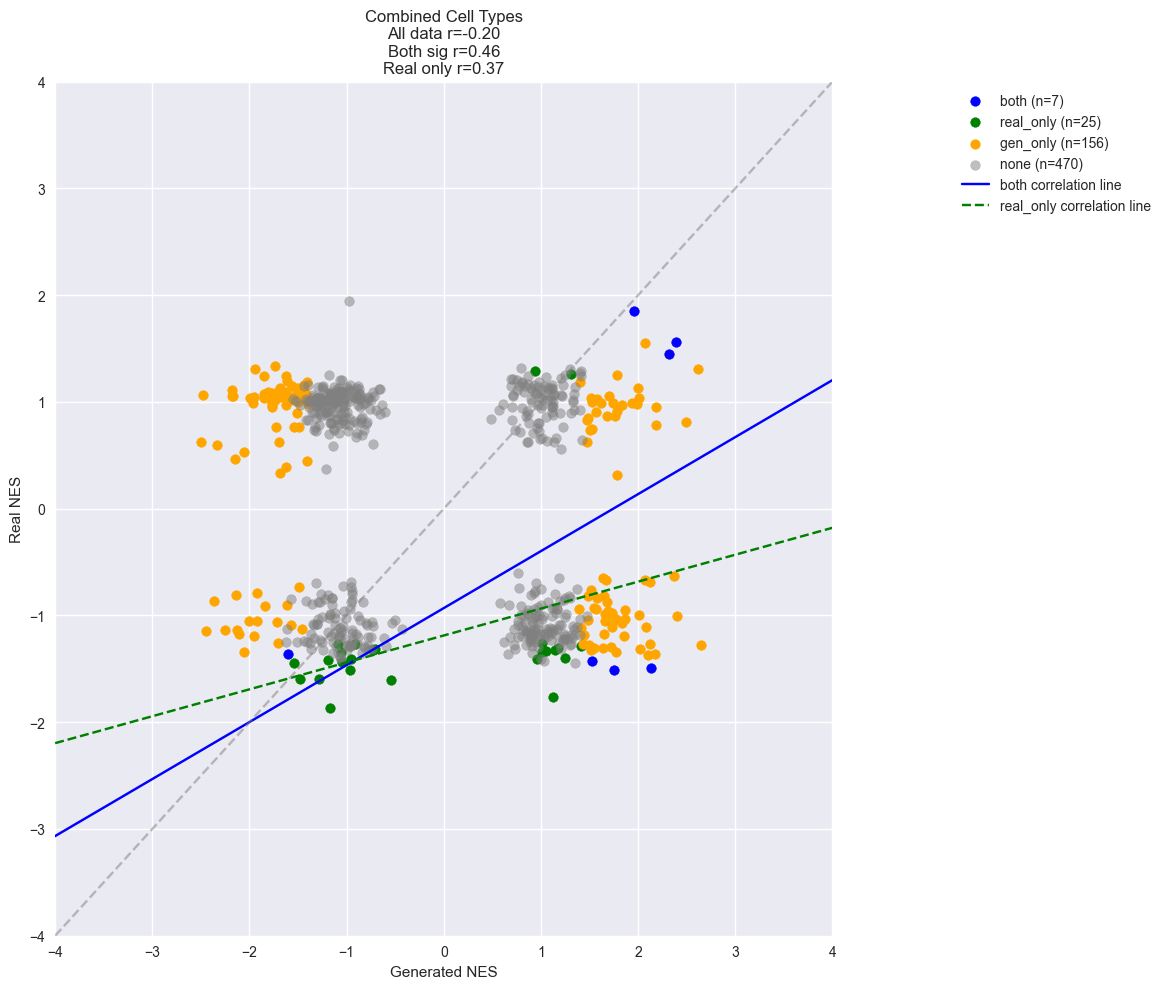


Summary Statistics:
all: 658 pathways (100.0%)
Correlation for all: -0.204

both: 7 pathways (1.1%)
Correlation for both: 0.455

real_only: 25 pathways (3.8%)
Correlation for real_only: 0.372

gen_only: 156 pathways (23.7%)

none: 470 pathways (71.4%)



In [77]:
## NES real VS generated, all cell types
# Create a new figure for the combined plot
plt.figure(figsize=(12, 10))

# Define colors for different significance categories (same as before)
color_map = {
    'both': 'blue',
    'real_only': 'green',
    'gen_only': 'orange',
    'none': 'gray'
}

# Process all data together
combined_data = merged_df.copy()

# Add p-values from both datasets
combined_data = combined_data.merge(
    df_gen[['Term', 'cell_type', 'FDR q-val']].rename(columns={'FDR q-val': 'pvalue_gen'}),
    on=['Term', 'cell_type']
)
combined_data = combined_data.merge(
    df_real[['Term', 'cell_type', 'FDR q-val']].rename(columns={'FDR q-val': 'pvalue_real'}),
    on=['Term', 'cell_type']
)

# Categorize points based on significance
combined_data['significance'] = 'none'
combined_data.loc[(combined_data['pvalue_gen'] < 0.1) & (combined_data['pvalue_real'] < 0.1), 'significance'] = 'both'
combined_data.loc[(combined_data['pvalue_real'] < 0.1) & (combined_data['pvalue_gen'] >= 0.1), 'significance'] = 'real_only'
combined_data.loc[(combined_data['pvalue_gen'] < 0.1) & (combined_data['pvalue_real'] >= 0.1), 'significance'] = 'gen_only'

# Calculate correlations for different categories
correlations = {}
for category in ['both', 'real_only', 'all']:
    if category == 'all':
        cat_data = combined_data
    else:
        cat_data = combined_data[combined_data['significance'] == category]
    
    if len(cat_data) > 1:
        corr, _ = scipy_stats.pearsonr(cat_data['NES_gen'], cat_data['NES_real'])
        correlations[category] = corr
    else:
        correlations[category] = float('nan')

# Plot points for each category
for category, color in color_map.items():
    cat_data = combined_data[combined_data['significance'] == category]
    alpha = 0.5 if category == 'none' else 1.0
    
    plt.scatter(
        cat_data['NES_gen'],
        cat_data['NES_real'],
        color=color,
        alpha=alpha,
        label=f"{category} (n={len(cat_data)})"
    )

# Add correlation lines for significant categories
for category, color in {'both': 'blue', 'real_only': 'green'}.items():
    cat_data = combined_data[combined_data['significance'] == category]
    if len(cat_data) > 1:
        z = np.polyfit(cat_data['NES_gen'], cat_data['NES_real'], 1)
        p = np.poly1d(z)
        x_range = np.array([-4, 4])
        plt.plot(x_range, p(x_range), color=color, 
                linestyle='-' if category == 'both' else '--',
                label=f"{category} correlation line")

# Set axis limits
plt.xlim(-4, 4)
plt.ylim(-4, 4)

# Add diagonal line
plt.plot([-4, 4], [-4, 4], '--', color='gray', alpha=0.5)

# Labels and title
plt.xlabel('Generated NES')
plt.ylabel('Real NES')
title_lines = ['Combined Cell Types']
title_lines.append(f"All data r={correlations['all']:.2f}")
if 'both' in correlations:
    title_lines.append(f"Both sig r={correlations['both']:.2f}")
if 'real_only' in correlations:
    title_lines.append(f"Real only r={correlations['real_only']:.2f}")
plt.title('\n'.join(title_lines))

# Add legend
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Save plot
plt.savefig(output_dir+'gsea_comparison_combined.pdf', bbox_inches='tight', dpi=400)
plt.show()

# Print some summary statistics
print("\nSummary Statistics:")
for category in ['all', 'both', 'real_only', 'gen_only', 'none']:
    count = len(combined_data[combined_data['significance'] == category]) if category != 'all' else len(combined_data)
    percentage = (count / len(combined_data)) * 100
    print(f"{category}: {count} pathways ({percentage:.1f}%)")
    
    if category in correlations:
        print(f"Correlation for {category}: {correlations[category]:.3f}")
    print()


Number of significant pathways (p < 0.1) in real data by cell type:
------------------------------------------------------------
B cells                 4 / 47   significant pathways (8.5%)
Dendritic cells         3 / 47   significant pathways (6.4%)
Endothelial cells       9 / 47   significant pathways (19.1%)
Erythrocytes           10 / 47   significant pathways (21.3%)
Fibroblasts             0 / 47   significant pathways (0.0%)
Skipping Fibroblasts - no significant pathways in real data
Granulocytes            1 / 47   significant pathways (2.1%)
Macrophages             2 / 47   significant pathways (4.3%)
Monocytes               0 / 47   significant pathways (0.0%)
Skipping Monocytes - no significant pathways in real data
NK cells                0 / 47   significant pathways (0.0%)
Skipping NK cells - no significant pathways in real data
T cells                 0 / 47   significant pathways (0.0%)
Skipping T cells - no significant pathways in real data
Adipocytes              0 /

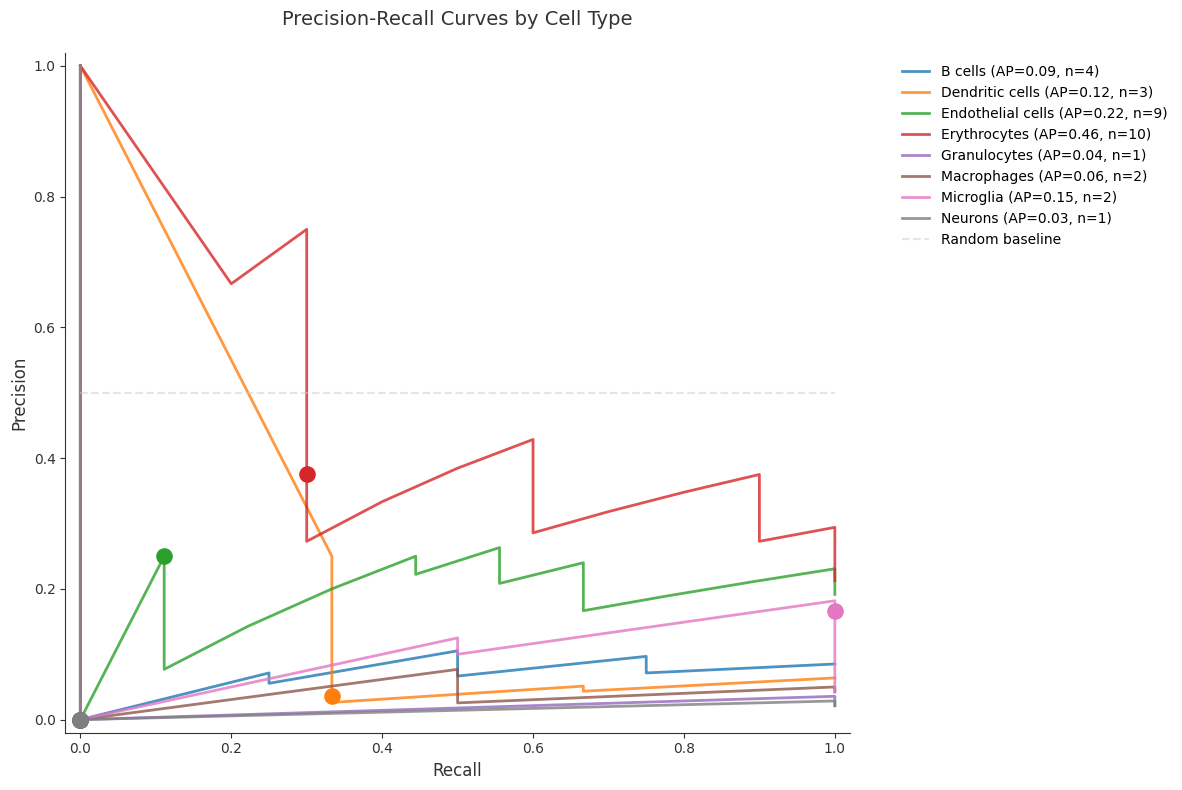


Performance Summary at p < 0.1:
Cell Type            Precision  Recall     AP        
--------------------------------------------------
B cells              0.000     0.000     0.090
Dendritic cells      0.036     0.333     0.122
Endothelial cells    0.250     0.111     0.220
Erythrocytes         0.375     0.300     0.456
Granulocytes         0.000     0.000     0.036
Macrophages          0.000     0.000     0.063
Microglia            0.167     1.000     0.153
Neurons              0.000     0.000     0.029

Average across all cell types with significant pathways:
Average              0.103     0.218     0.146


In [83]:
## Precision-Recall for gene sets
# Function to calculate precision-recall curves for each cell type
def calculate_pr_curves(merged_df, df_gen, df_real):
    pr_results = {}
    
    # Print statistics about significant pathways in real data
    print("\nNumber of significant pathways (p < 0.1) in real data by cell type:")
    print("-" * 60)
    
    for cell_type in merged_df['cell_type'].unique():
        # Get data for this cell type
        cell_data = merged_df[merged_df['cell_type'] == cell_type].merge(
            df_gen[['Term', 'cell_type', 'FDR q-val']].rename(columns={'FDR q-val': 'pvalue_gen'}),
            on=['Term', 'cell_type']
        ).merge(
            df_real[['Term', 'cell_type', 'FDR q-val']].rename(columns={'FDR q-val': 'pvalue_real'}),
            on=['Term', 'cell_type']
        )
        
        # Create binary labels (1 for significant in real data, 0 for not)
        y_true = (cell_data['pvalue_real'] < 0.1).astype(int)
        
        # Print statistics for this cell type
        n_total = len(y_true)
        n_sig = sum(y_true)
        print(f"{cell_type:<20} {n_sig:>4} / {n_total:<4} significant pathways ({n_sig/n_total*100:.1f}%)")
        
        # Skip cell types with no significant pathways in real data
        if n_sig == 0:
            print(f"Skipping {cell_type} - no significant pathways in real data")
            continue
            
        # Convert p-values to numeric, handling any string values
        pvalues = pd.to_numeric(cell_data['pvalue_gen'], errors='coerce')
        
        # Replace NaN and 0 with smallest positive float
        pvalues = pvalues.fillna(np.finfo(float).tiny)
        pvalues = np.maximum(pvalues, np.finfo(float).tiny)
        
        # Calculate -log10 scores
        scores = -np.log10(pvalues.astype(float))
        
        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_true, scores)
        
        # Calculate average precision
        ap = average_precision_score(y_true, scores)
        
        # Store results
        pr_results[cell_type] = {
            'precision': precision,
            'recall': recall,
            'thresholds': thresholds,
            'average_precision': ap,
            'n_significant': n_sig,
            'n_total': n_total
        }
        
        # Calculate actual precision and recall at p < 0.1
        pred = (pvalues < 0.1).astype(int)
        true_pos = np.sum((pred == 1) & (y_true == 1))
        false_pos = np.sum((pred == 1) & (y_true == 0))
        false_neg = np.sum((pred == 0) & (y_true == 1))
        
        precision_at_01 = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall_at_01 = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        
        pr_results[cell_type]['precision_at_01'] = precision_at_01
        pr_results[cell_type]['recall_at_01'] = recall_at_01

    return pr_results

# Calculate PR curves
pr_results = calculate_pr_curves(merged_df, df_gen, df_real)

if len(pr_results) > 0:
    # Set the style to white background
    plt.style.use('default')
    
    # Create figure with white background
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # Define a custom color palette (you can adjust these colors)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Plot individual PR curves
    for i, (cell_type, results) in enumerate(pr_results.items()):
        color = colors[i % len(colors)]
        
        # Plot the curve with higher alpha
        ax.plot(results['recall'], results['precision'], 
               label=f"{cell_type} (AP={results['average_precision']:.2f}, n={results['n_significant']})",
               color=color, alpha=0.8, linewidth=2)
        
        # Plot point at p < 0.1 with larger size
        ax.scatter(results['recall_at_01'], results['precision_at_01'], 
                  color=color, marker='o', s=120, zorder=5)

    # Plot random baseline with subtle style
    ax.plot([0, 1], [0.5, 0.5], '--', color='#cccccc', alpha=0.5, 
            label='Random baseline', linewidth=1.5)

    # Customize axis appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#333333')
    ax.spines['bottom'].set_color('#333333')
    
    # Customize ticks
    ax.tick_params(axis='both', colors='#333333')
    
    # Add labels with custom font size
    ax.set_xlabel('Recall', fontsize=12, color='#333333')
    ax.set_ylabel('Precision', fontsize=12, color='#333333')
    ax.set_title('Precision-Recall Curves by Cell Type', 
                fontsize=14, color='#333333', pad=20)

    # Customize axes limits with small padding
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)

    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
             frameon=True, fancybox=True, framealpha=1,
             edgecolor='none', fontsize=10)

    # Adjust layout to prevent legend cropping
    plt.tight_layout()

    # Save plot with high DPI
    plt.savefig(output_dir+'precision_recall_curves.pdf', 
                bbox_inches='tight', dpi=400, 
                facecolor='white', edgecolor='none')
    plt.show()

    # Print summary statistics
    print("\nPerformance Summary at p < 0.1:")
    print(f"{'Cell Type':<20} {'Precision':<10} {'Recall':<10} {'AP':<10}")
    print("-" * 50)
    for cell_type, results in pr_results.items():
        print(f"{cell_type:<20} {results['precision_at_01']:.3f}     {results['recall_at_01']:.3f}     {results['average_precision']:.3f}")

    # Calculate and print average metrics across all cell types
    avg_precision = np.mean([results['precision_at_01'] for results in pr_results.values()])
    avg_recall = np.mean([results['recall_at_01'] for results in pr_results.values()])
    avg_ap = np.mean([results['average_precision'] for results in pr_results.values()])

    print("\nAverage across all cell types with significant pathways:")
    print(f"{'Average':<20} {avg_precision:.3f}     {avg_recall:.3f}     {avg_ap:.3f}")
else:
    print("\nNo cell types had significant pathways in the real data.")

In [ ]:
"run_20250206_184657_dataset_singler_label"
"run_20250206_170233_dataset_singler_label"
"run_20250206_160000_dataset_singler_label"

Data loaded successfully
Number of rows: 14

Columns in the dataset: ['Unnamed: 0', 'cell_type', 'n_pathways', 't_statistic', 'p_value', 'correlation', 'correlation_p', 'p_value_adj', 'correlation_p_adj']

First few rows of p-values: 0    2.932426e-18
1    3.072113e-18
2    1.408284e-14
3    2.184354e-12
4    5.960263e-11
Name: p_value, dtype: float64


/var/folders/g_/c_f20pc566n31j9p36lcdc0w0000gn/T/ipykernel_30172/172517001.py:62: RuntimeWarning: divide by zero encountered in log10
  -np.log10(combined_p_t),
/var/folders/g_/c_f20pc566n31j9p36lcdc0w0000gn/T/ipykernel_30172/172517001.py:63: RuntimeWarning: divide by zero encountered in log10
  -np.log10(combined_p_z)]


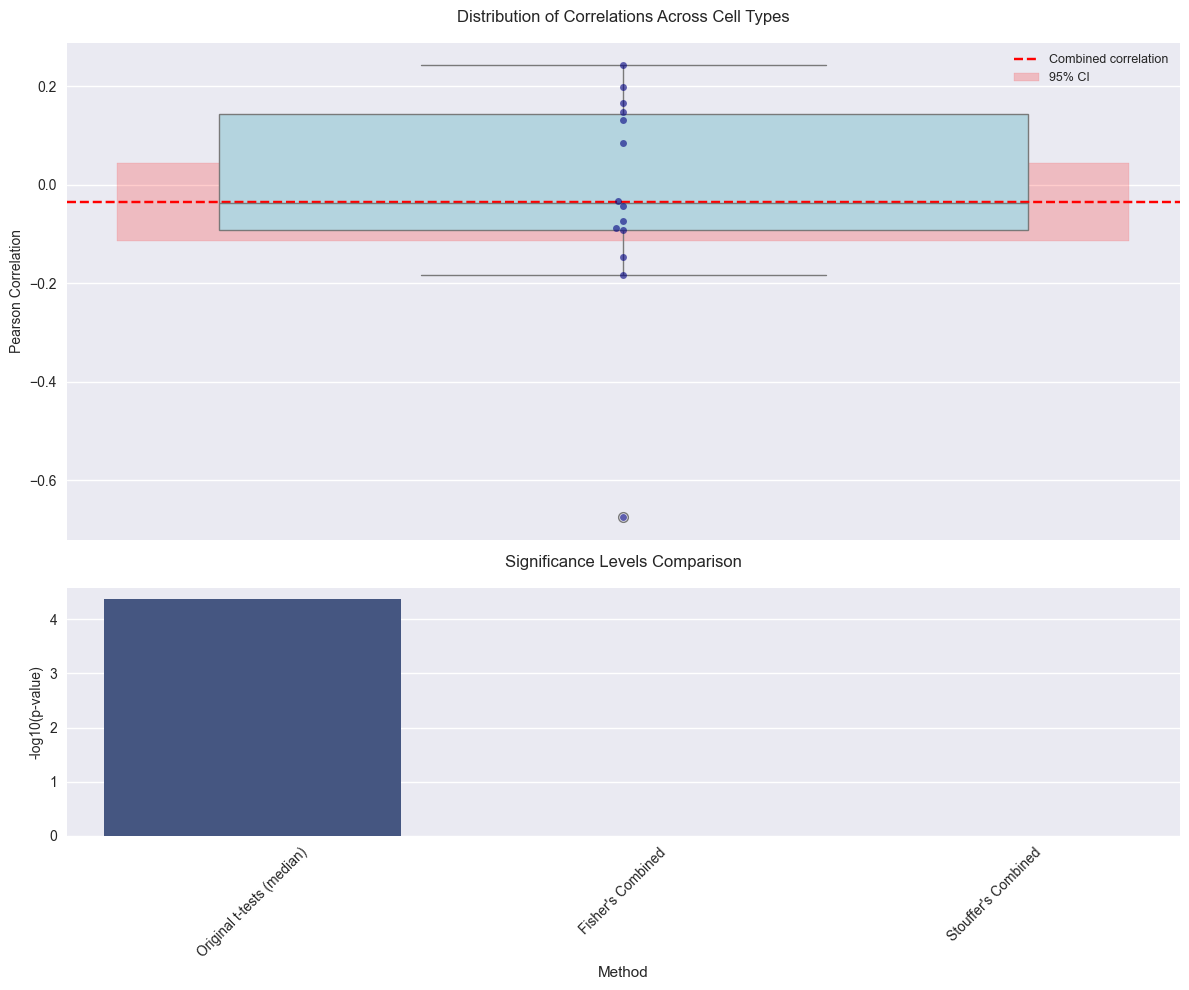


Explanation of Statistical Results:

1. Original t-tests:
   - Median p-value across cell types: 4.32e-05
   - These test whether there's a significant difference between generated and real NES values
   - A low p-value indicates that the differences are unlikely to occur by chance

2. Fisher's Combined Method:
   - Combined p-value: 0.00e+00
   - Combines evidence from all cell types' t-tests
   - Tests the global null hypothesis that all null hypotheses are true
   - Very sensitive to strong evidence from even a few cell types

3. Stouffer's Z-score Method:
   - Combined p-value: 0.00e+00
   - Weighted combination of evidence across cell types
   - More robust to outliers than Fisher's method
   - Weights each cell type by square root of sample size

4. Combined Correlation Analysis:
   - Combined correlation: -0.036
   - 95% CI: (-0.114, 0.043)
   - Measures overall agreement between generated and real NES values
   - Takes into account both direction and magnitude of relationships

In [ ]:

### Statistical analysis
# Load the results
results_df = pd.read_csv('/Users/guyshani/Documents/PHD/Aim_2/test_models/5000_genes/run_20250206_160000_dataset_singler_label/GSEA/statistical_results_coparison.csv')
    
# Print initial data check
print("Data loaded successfully")
print("Number of rows:", len(results_df))
print("\nColumns in the dataset:", results_df.columns.tolist())
print("\nFirst few rows of p-values:", results_df['p_value'].head())

# 1. Fisher's combined probability for t-test p-values
chi_square_t, combined_p_t = fishers_combined_probability(results_df['p_value'].values)

# 2. Fisher's Z-transformation for correlations
correlations = results_df['correlation'].values
sample_sizes = results_df['n_pathways'].values
combined_r, ci_r = fishers_z_transform(correlations, sample_sizes)

# 3. Convert t-statistics to z-scores and use Stouffer's method
z_scores = scipy_stats.norm.ppf(scipy_stats.t.sf(abs(results_df['t_statistic']), 
                                               df=results_df['n_pathways']-1))
weights = np.sqrt(results_df['n_pathways'])
combined_z, combined_p_z = stouffers_z_score(z_scores, weights)

# Create a summary DataFrame
summary_stats = pd.DataFrame({
    'Method': [
        "Fisher's Combined P-value (t-tests)",
        "Combined Correlation",
        "Correlation CI Lower",
        "Correlation CI Upper",
        "Stouffer's Combined Z-score",
        "Stouffer's Combined P-value"
    ],
    'Value': [
        combined_p_t,
        combined_r,
        ci_r[0],
        ci_r[1],
        combined_z,
        combined_p_z
    ]
})

# Print results
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Top plot: Correlation distribution and combined estimate
sns.boxplot(data=results_df, y='correlation', ax=ax1, color='lightblue')
sns.swarmplot(data=results_df, y='correlation', color='navy', alpha=0.6, ax=ax1)
ax1.axhline(y=combined_r, color='red', linestyle='--', label='Combined correlation')
ax1.fill_between([-0.5, 0.5], ci_r[0], ci_r[1], color='red', alpha=0.2, label='95% CI')
ax1.set_title('Distribution of Correlations Across Cell Types', fontsize=12, pad=15)
ax1.set_ylabel('Pearson Correlation', fontsize=10)
ax1.legend(fontsize=9)

# Bottom plot: P-values comparison
p_values = pd.DataFrame({
    'Method': ['Original t-tests (median)', "Fisher's Combined", "Stouffer's Combined"],
    'P-value': [results_df['p_value'].median(), combined_p_t, combined_p_z],
    '-log10(p)': [-np.log10(results_df['p_value'].median()), 
                  -np.log10(combined_p_t), 
                  -np.log10(combined_p_z)]
})

sns.barplot(data=p_values, x='Method', y='-log10(p)', ax=ax2, palette='viridis')
ax2.set_title('Significance Levels Comparison', fontsize=12, pad=15)
ax2.set_ylabel('-log10(p-value)', fontsize=10)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print explanation of the p-values
print("\nExplanation of Statistical Results:")
print("\n1. Original t-tests:")
print(f"   - Median p-value across cell types: {results_df['p_value'].median():.2e}")
print("   - These test whether there's a significant difference between generated and real NES values")
print("   - A low p-value indicates that the differences are unlikely to occur by chance")

print("\n2. Fisher's Combined Method:")
print(f"   - Combined p-value: {combined_p_t:.2e}")
print("   - Combines evidence from all cell types' t-tests")
print("   - Tests the global null hypothesis that all null hypotheses are true")
print("   - Very sensitive to strong evidence from even a few cell types")

print("\n3. Stouffer's Z-score Method:")
print(f"   - Combined p-value: {combined_p_z:.2e}")
print("   - Weighted combination of evidence across cell types")
print("   - More robust to outliers than Fisher's method")
print("   - Weights each cell type by square root of sample size")

print("\n4. Combined Correlation Analysis:")
print(f"   - Combined correlation: {combined_r:.3f}")
print(f"   - 95% CI: ({ci_r[0]:.3f}, {ci_r[1]:.3f})")
print("   - Measures overall agreement between generated and real NES values")
print("   - Takes into account both direction and magnitude of relationships")

if combined_r > 0.7:
    strength = "strong"
elif combined_r > 0.5:
    strength = "moderate"
else:
    strength = "weak"

print(f"\nOverall Assessment:")
print(f"The analysis shows a {strength} correlation (r = {combined_r:.3f}) between generated and real NES values.")
print(f"The extremely low p-values (p < 1e-10) across all methods suggest that this relationship is highly significant.")
print("The consistency across different statistical approaches strengthens confidence in these findings.")

In [63]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']